In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
df = spark.sql("show databases")
df.show(5)

+---------+
|namespace|
+---------+
|  default|
+---------+



In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Read the given CSV file
#from google.colab import files
#path = r'/content/drive/MyDrive/Colab Notebooks/'

In [6]:
#movie = spark.read.csv(path + 'movie.csv', inferSchema = True, header = True)
#occupation =spark.read.csv(path + 'occupation.csv',inferSchema=True,header=True)
#ratings =spark.read.csv(path + 'ratings.csv',inferSchema=True,header=True)
#users =spark.read.csv(path + 'users.csv',inferSchema=True,header=True)

In [7]:
movie = spark.read.csv('movie.csv', inferSchema = True, header = True)

In [8]:
occupation = spark.read.csv('occupation.csv', inferSchema = True, header = True)

In [9]:
ratings = spark.read.csv('ratings.csv', inferSchema = True, header = True)

In [10]:
users = spark.read.csv('users.csv', inferSchema = True, header = True)

In [11]:
movie = movie.select([c for c in movie.columns if c in {'MovieID', 'Title', 'Genres'}])
movie.limit(5).show()

+-------+--------------------+--------------------+
|MovieID|               Title|              Genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+



In [12]:
from pyspark.sql import functions as F

#import pyspark.sql.functions as F
#df.withColumn("check",F.col("text").rlike("yes").cast("Integer")).show()

genra_list = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
for genra in genra_list:
  movie = movie.withColumn(genra, F.col("Genres").rlike(genra).cast("Boolean"))

In [13]:
movie.limit(5).show()

+-------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|MovieID|               Title|              Genres|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|  War|Western|
+-------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|      1|    Toy Story (1995)|Animation|Childre...| false|    false|     true|      true|  true|false|      false|false|  false|    false| false|  false|  false|  false| false|   false|false|  false|
|      2|      Jumanji (1995)|Adventure|Childre...| false|     true|    false|      true| false|false|      false|false|   true|    false| false|  false|  false|  false| false|   false|false|  false|


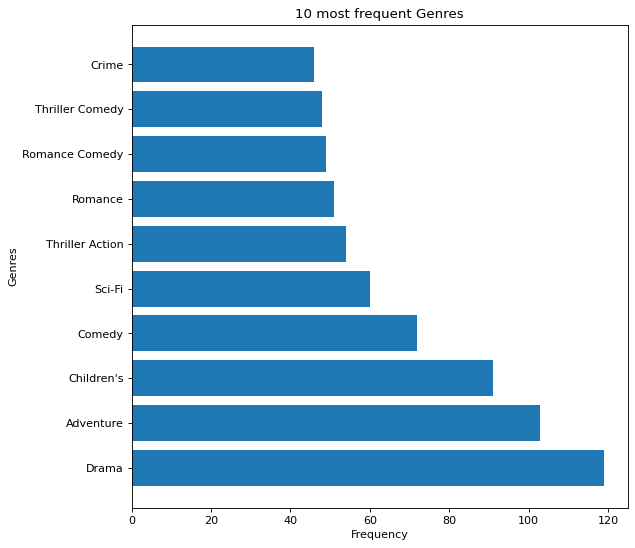

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

genres_list = movie.select('Genres').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(genres_list).split("|")).most_common(10)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]
plt.barh(words, counts)
plt.title("10 most frequent Genres")
plt.ylabel("Genres")
plt.xlabel("Frequency")
plt.show()

del genres_list,word_frequency

In [15]:
users.limit(5).show()
occupation.limit(5).show()
users_joined = users.join(occupation,["Occupation"],"leftouter")
users_joined.limit(5).show()

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     3|     M| 25|        15|   55117|
|     4|     M| 45|         7|    2460|
|     5|     M| 25|        20|   55455|
+------+------+---+----------+--------+

+----------+--------------------+
|Occupation|     Occupation_name|
+----------+--------------------+
|         0|               other|
|         1|   academic/educator|
|         2|              artist|
|         3|      clerical/admin|
|         4|college/grad student|
+----------+--------------------+

+----------+------+------+---+--------+--------------------+
|Occupation|UserID|Gender|Age|Zip-code|     Occupation_name|
+----------+------+------+---+--------+--------------------+
|        10|     1|     F|  1|   48067|        K-12 student|
|        16|     2|     M| 56|   70072|       self-employed|
|        15|     3|     M| 

In [16]:
users_joined.describe().show()

+-------+-----------------+------------------+------+------------------+-----------------+---------------+
|summary|       Occupation|            UserID|Gender|               Age|         Zip-code|Occupation_name|
+-------+-----------------+------------------+------+------------------+-----------------+---------------+
|  count|             6040|              6040|  6040|              6040|             6040|           6040|
|   mean|8.146854304635761|            3020.5|  null|30.639238410596025|87986.22464010713|           null|
| stddev|6.329511491401687|1743.7421445462246|  null|12.895961726906837|2499493.295731326|           null|
|    min|                0|                 1|     F|                 1|       01702-7224|   K-12 student|
|    max|               20|              6040|     M|                56|            99945|         writer|
+-------+-----------------+------------------+------+------------------+-----------------+---------------+



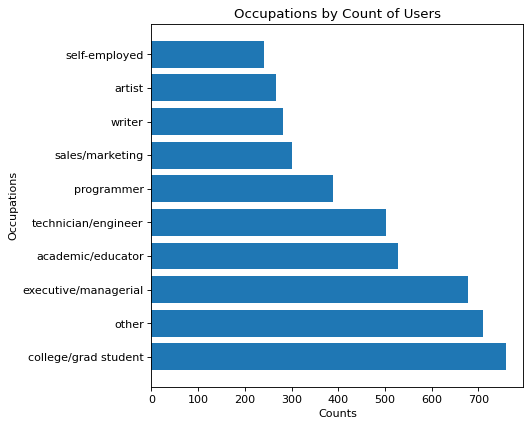

In [17]:
occupation_list = users_joined.select('Occupation_name').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(occupation_list).most_common(10)

occupations = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(6, 6), dpi=80)
plt.barh(occupations, counts)
plt.title("Occupations by Count of Users")
plt.ylabel("Occupations")
plt.xlabel("Counts")
plt.show()

del occupation_list,occupations,counts

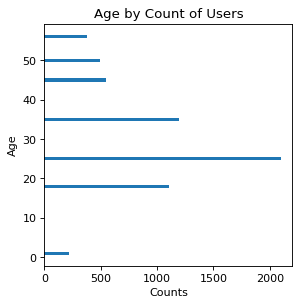

In [18]:
age = users_joined.select('Age').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(age).most_common()

age = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(4, 4), dpi=80)
plt.barh(age, counts)
plt.title("Age by Count of Users")
plt.ylabel("Age")
plt.xlabel("Counts")
plt.show()

del age,counts

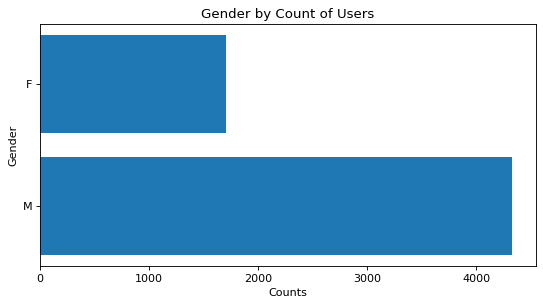

In [19]:
gender = users_joined.select('Gender').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(gender).most_common()

gender = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(8, 4), dpi=80)
plt.barh(gender, counts)
plt.title("Gender by Count of Users")
plt.ylabel("Gender")
plt.xlabel("Counts")
plt.show()

del gender,counts,frequency

In [20]:
ratings.describe().show()

+-------+-----------------+------------------+------------------+-------------------+
|summary|           UserID|           MovieID|            Rating|          Timestamp|
+-------+-----------------+------------------+------------------+-------------------+
|  count|          1000209|           1000209|           1000209|            1000209|
|   mean|3024.512347919285|1865.5398981612843| 3.581564453029317|9.722436954046655E8|
| stddev|1728.412694899932|1096.0406894572586|1.1171018453732577|1.215255893991719E7|
|    min|                1|                 1|                 1|          956703932|
|    max|             6040|              3952|                 5|         1046454590|
+-------+-----------------+------------------+------------------+-------------------+



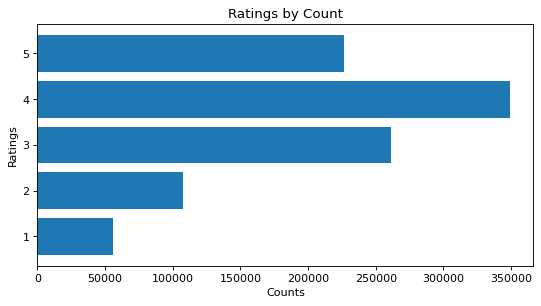

In [21]:
rating = ratings.select('Rating').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(rating).most_common()

rating = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(8, 4), dpi=80)
plt.barh(rating, counts)
plt.title("Ratings by Count")
plt.ylabel("Ratings")
plt.xlabel("Counts")
plt.show()

del rating,counts,frequency

In [22]:
master = ratings.join(users_joined,["UserId"],"leftouter").join(movie,["MovieID"],"leftouter" )
#master = master.drop(*['UserID','MovieID','Occupation','MovieID'])

In [23]:
master.show(5)

+-------+------+------+---------+----------+------+---+--------+-------------------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|MovieID|UserID|Rating|Timestamp|Occupation|Gender|Age|Zip-code|    Occupation_name|               Title|              Genres|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|  War|Western|
+-------+------+------+---------+----------+------+---+--------+-------------------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|   2987|   148|     5|979576038|        17|     M| 50|   57747|technician/engineer|Who Framed Roger ...|Adventure|Animati...| false|     true|     true|     false| false|fals

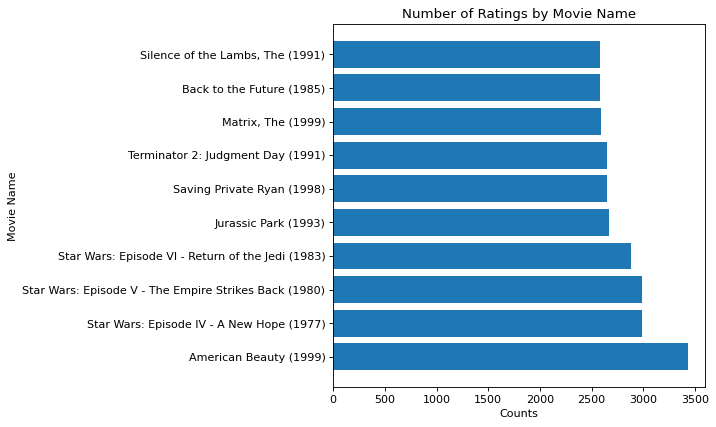

In [24]:
movie_name = master.select('Title').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(movie_name).most_common(10)

movie_name = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(6, 6), dpi=80)
plt.barh(movie_name, counts)
plt.title("Number of Ratings by Movie Name")
plt.ylabel("Movie Name")
plt.xlabel("Counts")
plt.show()

del movie_name,counts,frequency

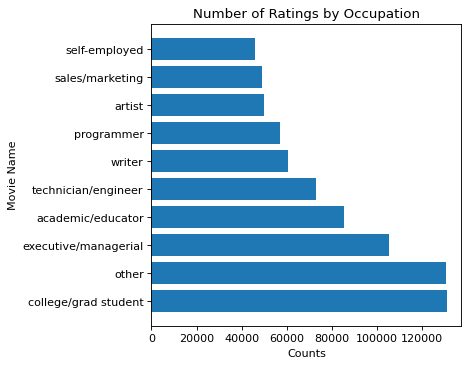

In [25]:
occupation_rate = master.select('Occupation_name').rdd.map(lambda x : x[0]).collect()

# Assign the Counter instance 
frequency = Counter(occupation_rate).most_common(10)

occupation_name = [word for word, _ in frequency]
counts = [counts for _, counts in frequency]

figure(figsize=(5, 5), dpi=80)
plt.barh(occupation_name, counts)
plt.title("Number of Ratings by Occupation")
plt.ylabel("Movie Name")
plt.xlabel("Counts")
plt.show()

del occupation_rate,counts,frequency

In [26]:
master.show(2)

+-------+------+------+---------+----------+------+---+--------+-------------------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|MovieID|UserID|Rating|Timestamp|Occupation|Gender|Age|Zip-code|    Occupation_name|               Title|              Genres|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|  War|Western|
+-------+------+------+---------+----------+------+---+--------+-------------------+--------------------+--------------------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+-----+-------+
|   2987|   148|     5|979576038|        17|     M| 50|   57747|technician/engineer|Who Framed Roger ...|Adventure|Animati...| false|     true|     true|     false| false|fals

In [27]:
master = master.select(['MovieID','UserID','Rating','Genres','Title'])

In [28]:
master.show(5)

+-------+------+------+--------------------+--------------------+
|MovieID|UserID|Rating|              Genres|               Title|
+-------+------+------+--------------------+--------------------+
|   1193|     1|     5|               Drama|One Flew Over the...|
|    661|     1|     3|Animation|Childre...|James and the Gia...|
|    914|     1|     3|     Musical|Romance| My Fair Lady (1964)|
|   3408|     1|     4|               Drama|Erin Brockovich (...|
|   2355|     1|     5|Animation|Childre...|Bug's Life, A (1998)|
+-------+------+------+--------------------+--------------------+
only showing top 5 rows



In [29]:
# Importing the required libraries to perform ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [30]:
from pyspark.sql import functions as f

In [31]:
# Removes users with less than 20 ratings
master.groupBy("UserID").count().filter(f.col("count") >= 50).show()

+------+-----+
|UserID|count|
+------+-----+
|   148|  624|
|   463|  123|
|   471|  105|
|   496|  119|
|  1088| 1176|
|  1342|   92|
|  1591|  314|
|  1645|  522|
|  1959|   61|
|  2122|  208|
|  2142|   77|
|  2659|  161|
|  2866|  205|
|  3175|   87|
|  3749|  118|
|  3997|  315|
|  4101|   95|
|  4818|   50|
|  5156|  320|
|  5300|  282|
+------+-----+
only showing top 20 rows



In [32]:
# Split our data for our training and test datasets
(train, test) = master.randomSplit([0.8, 0.2])

In [33]:
train.describe().show()

+-------+------------------+------------------+-----------------+-------+--------------------+
|summary|           MovieID|            UserID|           Rating| Genres|               Title|
+-------+------------------+------------------+-----------------+-------+--------------------+
|  count|            800253|            800253|           800253| 800253|              800253|
|   mean|1865.3822703569997|3024.3768595681618|3.580870049846736|   null|                null|
| stddev|1096.0108405961018|1728.5135512146749|1.117072717447363|   null|                null|
|    min|                 1|                 1|                1| Action|$1,000,000 Duck (...|
|    max|              3952|              6040|                5|Western|     eXistenZ (1999)|
+-------+------------------+------------------+-----------------+-------+--------------------+



In [34]:
test.describe().show(5)

+-------+------------------+------------------+------------------+-------+--------------------+
|summary|           MovieID|            UserID|            Rating| Genres|               Title|
+-------+------------------+------------------+------------------+-------+--------------------+
|  count|            199956|            199956|            199956| 199956|              199956|
|   mean|1866.1707475644641|3025.0545920102422|3.5843435555822283|   null|                null|
| stddev| 1096.162654782115|1728.0132094929415|1.1172168852682534|   null|                null|
|    min|                 1|                 1|                 1| Action|$1,000,000 Duck (...|
|    max|              3952|              6040|                 5|Western|     eXistenZ (1999)|
+-------+------------------+------------------+------------------+-------+--------------------+



In [35]:
# Run ALS collaborative filtering
als = ALS(rank=16, maxIter=10, regParam=0.16, userCol="UserID", itemCol="MovieID", ratingCol="Rating")

# Run training model which includes your own ratings
#model = als.fit(train)
model = als.fit(train.unionAll(master))

In [36]:
predictions = model.transform(test).dropna()
predictions.createOrReplaceTempView("predictions")
display(predictions)

DataFrame[MovieID: int, UserID: int, Rating: int, Genres: string, Title: string, prediction: float]

In [37]:
predictions.show()

+-------+------+------+--------------------+--------------------+----------+
|MovieID|UserID|Rating|              Genres|               Title|prediction|
+-------+------+------+--------------------+--------------------+----------+
|    148|   673|     5|               Drama|Awfully Big Adven...| 3.2135835|
|    148|  4169|     3|               Drama|Awfully Big Adven...| 2.8268285|
|    148|  4227|     2|               Drama|Awfully Big Adven...| 2.2349353|
|    148|  4784|     3|               Drama|Awfully Big Adven...| 2.8330445|
|    148|  1069|     2|               Drama|Awfully Big Adven...| 2.6612728|
|    148|  1150|     2|               Drama|Awfully Big Adven...| 2.3446913|
|    463|    26|     3|Crime|Drama|Thriller|Guilty as Sin (1993)|  2.511301|
|    463|  3032|     4|Crime|Drama|Thriller|Guilty as Sin (1993)|  3.853269|
|    463|  3562|     2|Crime|Drama|Thriller|Guilty as Sin (1993)| 2.7485409|
|    463|  4613|     4|Crime|Drama|Thriller|Guilty as Sin (1993)|  3.602999|

In [38]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

In [43]:
print(rmse, '\nThe predictions model has an RMSE of approximately 0.89. \nThis indicates that it predicts values that are typically 0.89 above or below those in the original ratings matrix. \nNote that matrix factorization reveals patterns that humans are unable to.')

0.8923814918030123 
The predictions model has an RMSE of approximately 0.89. 
This indicates that it predicts values that are typically 0.89 above or below those in the original ratings matrix. 
Note that matrix factorization reveals patterns that humans are unable to.
